# CFL on Galaxy Dataset 
This notebook runs CFL on the galaxy dataset and visualizes the results. X data is comprised of two input images (a gas map and dark matter map). Y data is comprised of six parameters describing the simulated telescope image that results from these input maps.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys

import cfl
from cfl.cfl_wrapper import make_CFL
from cfl.save.experiment_saver import ExperimentSaver
from cfl.dataset import Dataset

# Load and Inspect Dataset

In [2]:
# load data
cfl_path = '/Users/imanwahle/Desktop/cfl'
Xraw = np.load(os.path.join(cfl_path, 'data/galaxies/X.npy'))
Yraw = np.load(os.path.join(cfl_path, 'data/galaxies/Y.npy'))
print('Xraw shape: ', Xraw.shape)
print('Yraw shape: ', Yraw.shape)

Xraw shape:  (8643, 5202)
Yraw shape:  (8643, 6)


min, max raw img 0: -111209.03876876831, 0.0
min, max raw img 1: 0.0, 73430.0


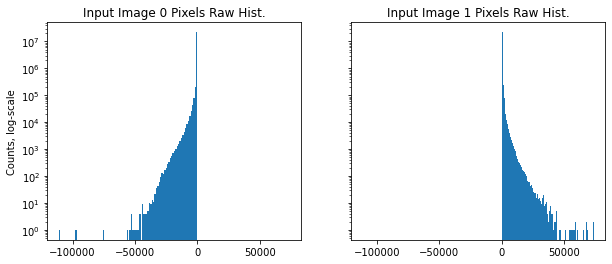

In [3]:
print('min, max raw img 0: {}, {}'.format(np.min(Xraw[:,:2601]),np.max(Xraw[:,:2601])))
print('min, max raw img 1: {}, {}'.format(np.min(Xraw[:,2601:]),np.max(Xraw[:,2601:])))
fig,ax = plt.subplots(1,2,figsize=(10,4), sharex=True, sharey=True)
ax[0].hist(np.ravel(Xraw[:,:2601]),100)
ax[0].set_title('Input Image 0 Pixels Raw Hist.')
ax[0].set_yscale('log')
ax[0].set_ylabel('Counts, log-scale')
ax[1].hist(np.ravel(Xraw[:,2601:]),100)
ax[1].set_title('Input Image 1 Pixels Raw Hist.')
ax[0].set_yscale('log')
plt.show()

# these are counts of pixel values

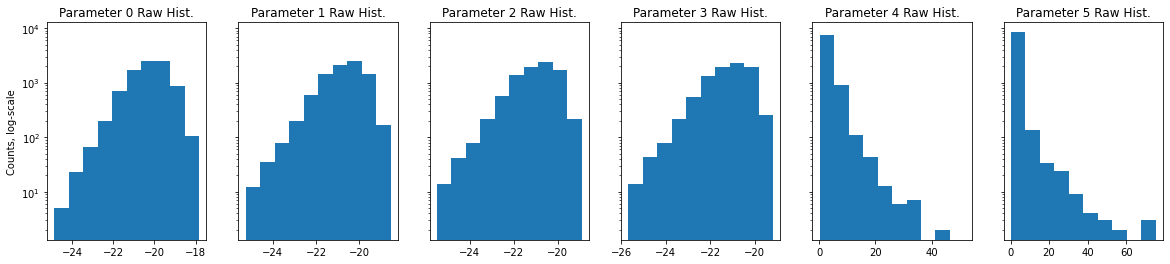

In [4]:
fig,ax = plt.subplots(1,6,figsize=(20,4), sharex=False, sharey=True)
for i in range(6):
    ax[i].hist(Yraw[:,i],10)
    ax[i].set_title('Parameter {} Raw Hist.'.format(i))
    ax[i].set_yscale('log') 
ax[0].set_ylabel('Counts, log-scale')
plt.show()

# these first four shouldn't share so much of their range
# the last two being similar isn't a concern

# Rescale Data

In [5]:
# Xraw data should be arcsinhed and scaled 0-1
X = np.arcsinh(Xraw)
X = X - X.min(axis=0)
X = X / X.max(axis=0)

# Yraw should be z-scored
Y = Yraw - Yraw.mean(axis=0)
Y = Y / Y.std(axis=0)

min, max img 0: 0.0, 1.0
min, max img 1: 0.0, 1.0


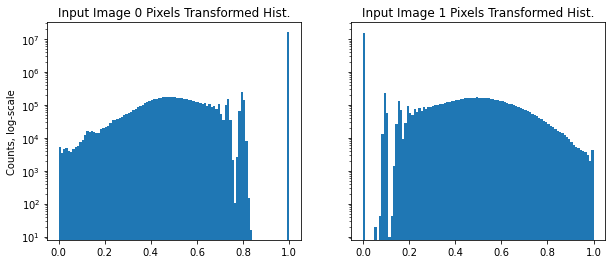

In [6]:
print('min, max img 0: {}, {}'.format(np.min(X[:,:2601]),np.max(X[:,:2601])))
print('min, max img 1: {}, {}'.format(np.min(X[:,2601:]),np.max(X[:,2601:])))

fig,ax = plt.subplots(1,2,figsize=(10,4), sharex=True, sharey=True)
ax[0].hist(np.ravel(X[:,:2601]),100)
ax[0].set_title('Input Image 0 Pixels Transformed Hist.')
ax[0].set_yscale('log')
ax[0].set_ylabel('Counts, log-scale')
ax[1].hist(np.ravel(X[:,2601:]),100)
ax[1].set_title('Input Image 1 Pixels Transformed Hist.')
ax[1].set_yscale('log')
plt.show()


param 0 min: -5.084923879152289, max: 2.6816166006810707
param 1 min: -4.835309458724446, max: 2.3333343493773886
param 2 min: -4.71837822619073, max: 2.1926626890132592
param 3 min: -4.648840457422656, max: 2.1117426606850382
param 4 min: -1.1953675147308491, max: 17.887880401785317
param 5 min: -0.36990860551779914, max: 22.570458850880186


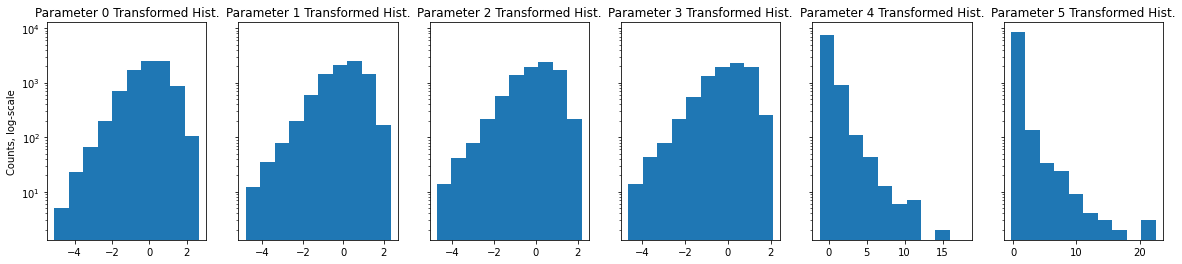

In [7]:
fig,ax = plt.subplots(1,6,figsize=(20,4), sharex=False, sharey=True)
for i in range(6):
    ax[i].hist(Y[:,i],10)
    ax[i].set_title('Parameter {} Transformed Hist.'.format(i))
    ax[i].set_yscale('log')
    print('param {} min: {}, max: {}'.format(i, np.min(Y[:,i]),np.max(Y[:,i])))
ax[0].set_ylabel('Counts, log-scale')
plt.show()


# Run CFL

In [8]:
# start experiment
experiment_saver = ExperimentSaver('results/galaxies')

# register dataset
dataset0 = Dataset(X, Y, dataset_label='dataset0', experiment_saver=experiment_saver)

All results from this run will be saved to results/galaxies/experiment0003


In [9]:
# specify CFL parameters

# generic data parameters
data_info = { 'X_dims' : X.shape, 
              'Y_dims' : Y.shape } 

# conditional density estimator parameters
CDE_params = { 'batch_size'  : 64,
               'optimizer'   : 'adam',
               'n_epochs'    : 150,
               'verbose'     : 1,
               'opt_config'  : {'lr': 1e-4},
               'dense_units' : [1000, 100, data_info['Y_dims'][1]],
               'activations' : ['relu', 'relu', 'linear'],
               'dropouts'    : [0.1, 0.1, 0], 
               'show_plot'   : True,
               'weights_path': 'results/galaxies/experiment0000/dataset0/checkpoints/best_weights' }

    
# clusterer parameters
cluster_params = { 'n_Xclusters' : 4, 
                   'n_Yclusters' : 4 }

In [10]:
# build CFL object! 
cfl_object = make_CFL(  data_info=data_info, 
                        CDE_type='CondExpMod', 
                        cluster_type='Kmeans', 
                        CDE_params=CDE_params, 
                        cluster_params=cluster_params,
                        experiment_saver=experiment_saver) 

loss not specified in params, defaulting to mean_squared_error
model_name not specified in params, defaulting to CondExpMod
Loading parameters from  results/galaxies/experiment0000/dataset0/checkpoints/best_weights


In [11]:
# train
train_results = cfl_object.train(dataset0, standardize=False)

No need to train, specified weights loaded already.
100%|██████████| 8643/8643 [00:16<00:00, 523.52it/s]


In [12]:
# predict
dataset1 = Dataset(X[:,:], Y[:,:], dataset_label='dataset1', experiment_saver=experiment_saver) 
xlbls,ylbls = cfl_object.predict(dataset1)


100%|██████████| 8643/8643 [00:13<00:00, 643.67it/s]


# Visualize Examples from X Macrovar Classes

In [13]:
from galaxy_util import reshape_input, calculate_arp

Examples of Input Image 0 by Class


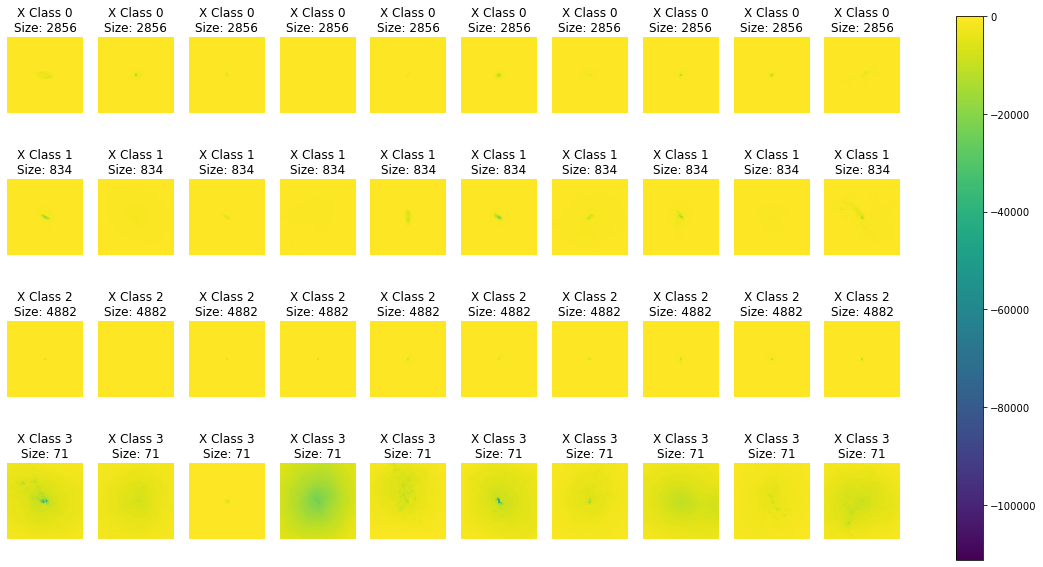

In [14]:
print('Examples of Input Image 0 by Class')
fig,ax = plt.subplots(cluster_params['n_Xclusters'], 10, figsize=(20,10))
figmin = np.min(Xraw[:,:2601])
figmax = np.max(Xraw[:,:2601])
for i in range(cluster_params['n_Xclusters']):
    class_idx = np.where(xlbls==i)[0]
    class_samples = np.random.choice(class_idx, 10)
    for j in range(10):
        im = ax[i,j].imshow(reshape_input(Xraw[class_samples[j]],0), vmin=figmin, vmax=figmax)
        ax[i,j].set_title('class {}'.format(i))
        ax[i,j].axis('off')
        ax[i,j].set_title('X Class {}\nSize: {}'.format(i, np.sum(xlbls==i)))
fig.colorbar(im, ax=ax)
plt.show()


Examples of Input Image 1 by Class


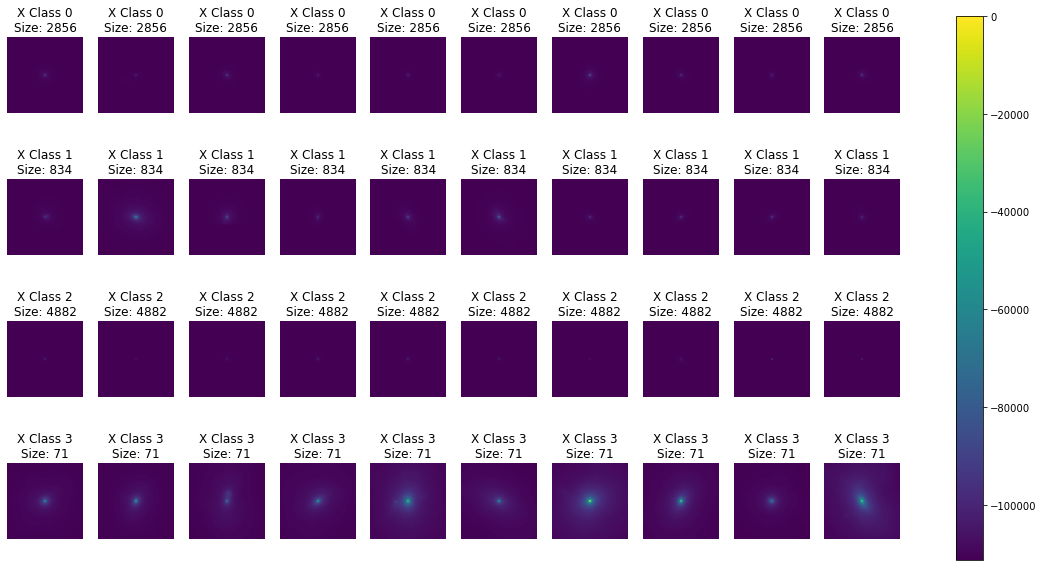

In [15]:
print('Examples of Input Image 1 by Class')
fig,ax = plt.subplots(cluster_params['n_Xclusters'], 10, figsize=(20,10))
figmin = np.min(Xraw[:,2601:])
figmax = np.max(Xraw[:,2601:])
for i in range(cluster_params['n_Xclusters']):
    class_idx = np.where(xlbls==i)[0]
    class_samples = np.random.choice(class_idx, 10)
    for j in range(10):
        ax[i,j].imshow(reshape_input(Xraw[class_samples[j]],1),vmin=figmin, vmax=figmax)
        ax[i,j].set_title('class {}'.format(i))
        ax[i,j].axis('off')
        ax[i,j].set_title('X Class {}\nSize: {}'.format(i, np.sum(xlbls==i)))
fig.colorbar(im, ax=ax)
plt.show()


# Visualize Average of Each X Macrovar Class

Average of Input Image 0 by X Macrovariable Class


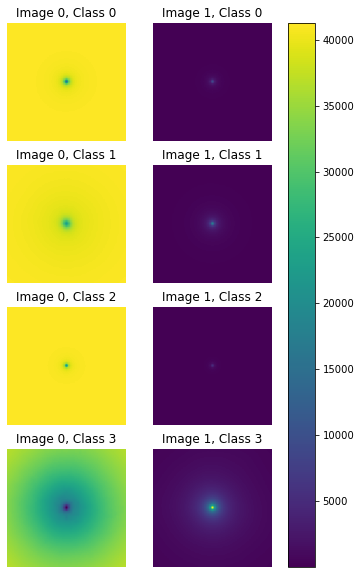

In [16]:
print('Average of Input Image 0 by X Macrovariable Class')
fig,ax = plt.subplots(cluster_params['n_Xclusters'], 2, figsize=(6,10))
class_means = np.zeros((cluster_params['n_Xclusters'], Xraw.shape[1]))
for i in range(cluster_params['n_Xclusters']):
    class_means[i,:] = np.mean(Xraw[xlbls==i,:],axis=0)
vmin = np.min(class_means[:,:2601]), np.min(class_means[:,2601:])
vmax = np.max(class_means[:,:2601]), np.max(class_means[:,2601:])
for i in range(cluster_params['n_Xclusters']):
    for j in range(2):
        im = ax[i,j].imshow(reshape_input(class_means[i], j), vmin=vmin[j], vmax=vmax[j])
        ax[i,j].set_title('Image {}, Class {}'.format(j,i))
        ax[i,j].axis('off')

fig.colorbar(im, ax=ax)
plt.show()


# Plot Average Radial Profile (ARP)

In [17]:
# Make temporary X for plotting
Xtmp = Xraw - Xraw.min() # make sure everything is positive for plotting on loglog

Example input RAW image1 and corresponding ARP:


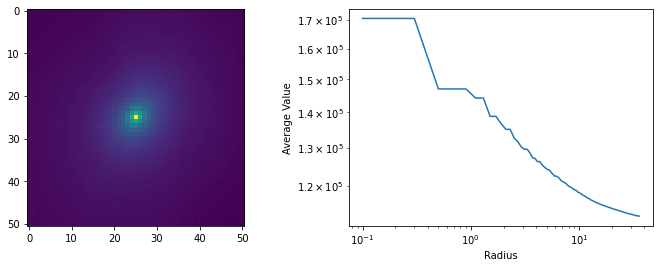

In [18]:
print('Example input RAW image1 and corresponding ARP:')
fig,ax = plt.subplots(1,2,figsize=(12,4))
tmp_image = Xtmp[0,2601:].reshape((51,51))
ax[0].imshow(tmp_image)

r, mean = calculate_arp(tmp_image)
ax[1].loglog(r, mean)
ax[1].set_xlabel('Radius')
ax[1].set_ylabel('Average Value')
plt.show()

Examples of Input RAW image1 ARP by Class, log-log scale


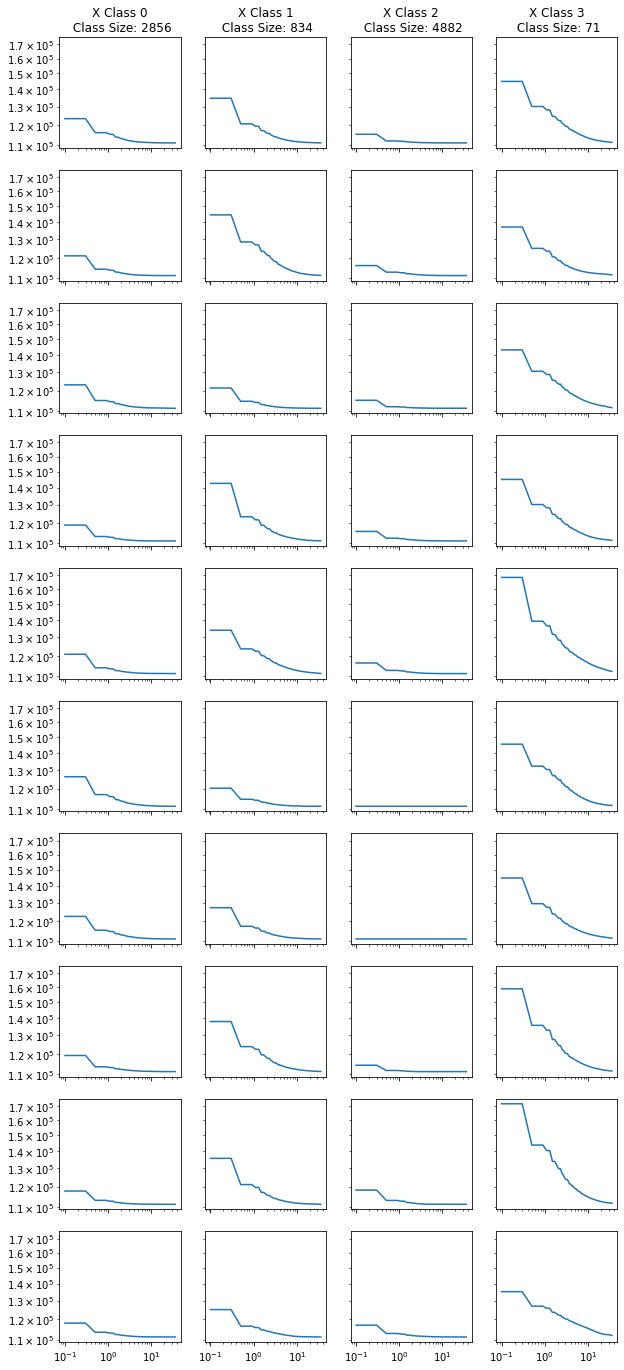

In [19]:
print('Examples of Input RAW image1 ARP by Class, log-log scale')
fig,ax = plt.subplots(10, cluster_params['n_Xclusters'], figsize=(10,24), sharex=True, sharey=True)
figmin = np.min(Xtmp[:,2601:])
figmax = np.max(Xtmp[:,2601:])
for i in range(cluster_params['n_Xclusters']):
    class_idx = np.where(xlbls==i)[0]
    class_samples = np.random.choice(class_idx, 10)
    for j in range(10):
        r, mean = calculate_arp(reshape_input(Xtmp[class_samples[j]], im_no=1))
        im = ax[j,i].loglog(r, mean)
        if j==0:
            ax[j,i].set_title('X Class {}\n Class Size: {}'.format(i, np.sum(xlbls==i)))
plt.show()


Average of Input RAW image1 ARPs by Class. Blue = average.


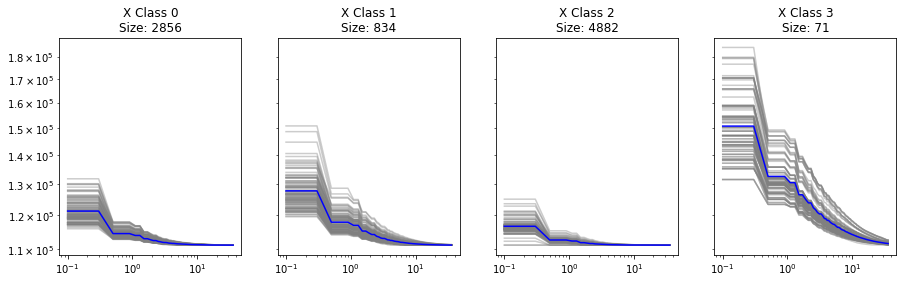

In [20]:
print('Average of Input RAW image1 ARPs by Class. Blue = average.')
fig,ax = plt.subplots(1, cluster_params['n_Xclusters'], figsize=(15,4), sharex=True, sharey=True)
figmin = np.min(Xtmp[:,2601:])
figmax = np.max(Xtmp[:,2601:])
for i in range(cluster_params['n_Xclusters']):
    class_idx = np.where(xlbls==i)[0]
    class_samples = np.random.choice(class_idx, 100)
    means = np.zeros((100,200))
    for j in range(100):
        r, mean = calculate_arp(reshape_input(Xtmp[class_samples[j]], im_no=1))
        means[j] = mean
        im = ax[i].loglog(r, mean, c='gray',alpha=0.4)
    ax[i].loglog(r, means.mean(axis=0), c='blue')
    ax[i].set_title('X Class {}\nSize: {}'.format(i, np.sum(xlbls==i)))

plt.show()


Average of Input RAW image0 ARPs by Class. Blue = average.


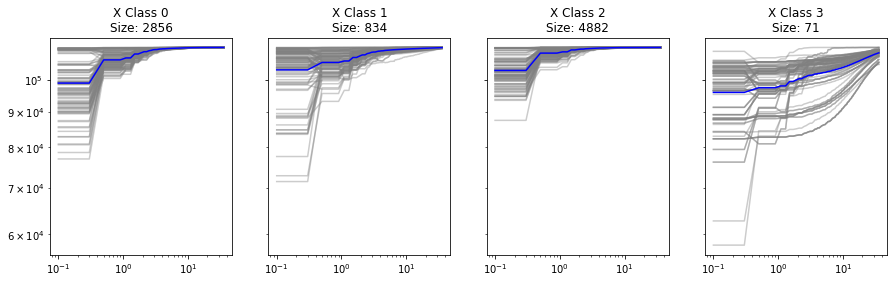

In [21]:
print('Average of Input RAW image0 ARPs by Class. Blue = average.')
fig,ax = plt.subplots(1, cluster_params['n_Xclusters'], figsize=(15,4), sharex=True, sharey=True)
figmin = np.min(Xtmp[:,:2601])
figmax = np.max(Xtmp[:,:2601])
for i in range(cluster_params['n_Xclusters']):
    class_idx = np.where(xlbls==i)[0]
    class_samples = np.random.choice(class_idx, 100)
    means = np.zeros((100,200))
    for j in range(100):
        r, mean = calculate_arp(reshape_input(Xtmp[class_samples[j]], im_no=0))
        means[j] = mean
        im = ax[i].loglog(r, mean, c='gray',alpha=0.4)
    ax[i].loglog(r, means.mean(axis=0), c='blue')
    ax[i].set_title('X Class {}\nSize: {}'.format(i, np.sum(xlbls==i)))

plt.show()


# PCA Visualizations

In [22]:
from sklearn.decomposition import PCA

In [23]:
# do PCA
pca = PCA(n_components=Xraw.shape[1])
Xred = pca.fit_transform(Xraw)

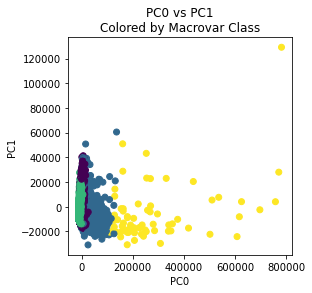

In [24]:
# scatter first two PCs
fig,ax = plt.subplots(figsize=(4,4))
ax.scatter(Xred[:,0],Xred[:,1], c=xlbls)
ax.set_title('PC0 vs PC1\nColored by Macrovar Class')
ax.set_xlabel('PC0')
ax.set_ylabel('PC1')
plt.show()

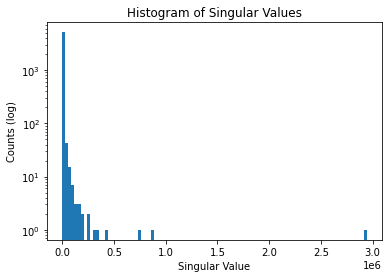

In [25]:
# plot distributions of singular values
fig,ax = plt.subplots()
ax.hist(pca.singular_values_, 100)
ax.set_title('Histogram of Singular Values')
ax.set_yscale('log')
ax.set_xlabel('Singular Value')
ax.set_ylabel('Counts (log)')
plt.show()

In [26]:
# reload(galaxy_util)
# from galaxy_util import calculate_arp, multiline

Image 0: PCA principal axes


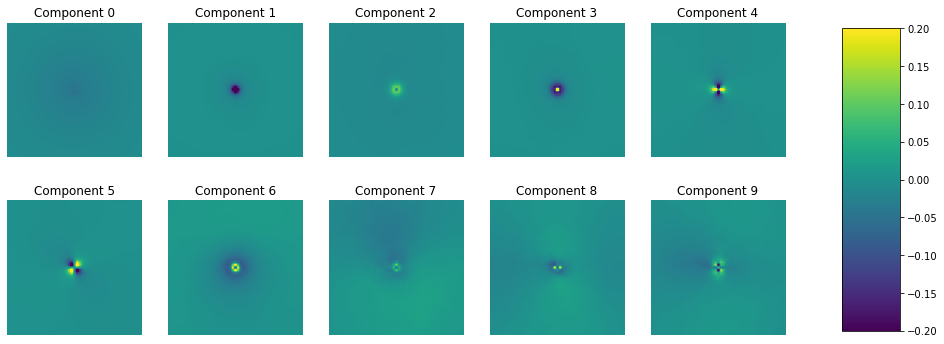


Image 1: PCA principal axes


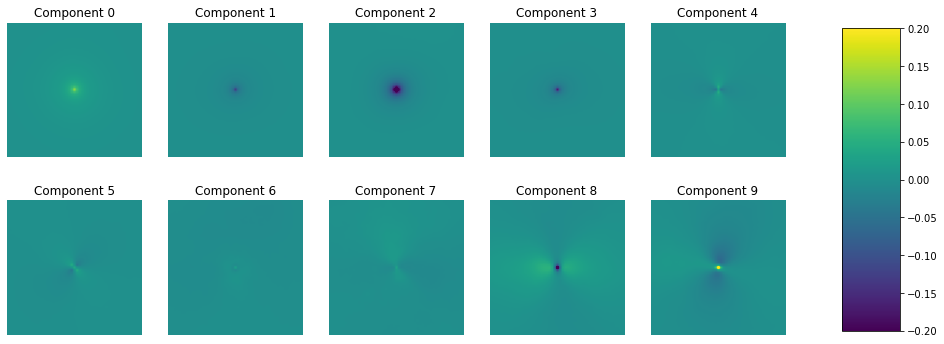

In [27]:
# plot principal axes in feature space (i.e. directions of max variance)
eigenvecs = pca.components_
vmin = np.arcsinh(eigenvecs.min())
vmax = np.arcsinh(eigenvecs.max())
for imgi in range(2):
    print ('Image {}: PCA principal axes'.format(imgi))
    fig,axs=plt.subplots(2,5,figsize=(16,6))
    # for each eigenvector, compute the ARP of each 'image'
    for comp,ax in zip(range(eigenvecs.shape[0]),axs.ravel()):
        
        im = ax.imshow(np.arcsinh(reshape_input(eigenvecs[comp,:],im_no=imgi)), vmin=-0.2, vmax=0.2)
        ax.set_title('Component {}'.format(comp))
        ax.axis('off')
    fig.subplots_adjust(right=0.8)
    cax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    fig.colorbar(im,cax)
    plt.show()
    print()



Image 0: PCA principal axes ARP (arcsinh


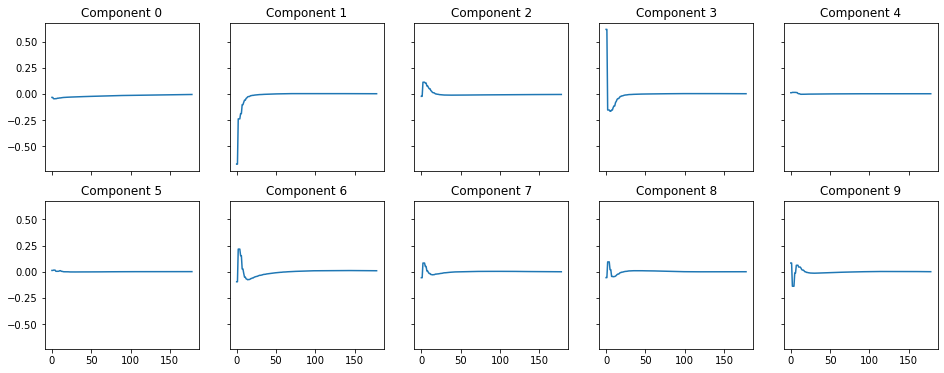


Image 1: PCA principal axes ARP (arcsinh


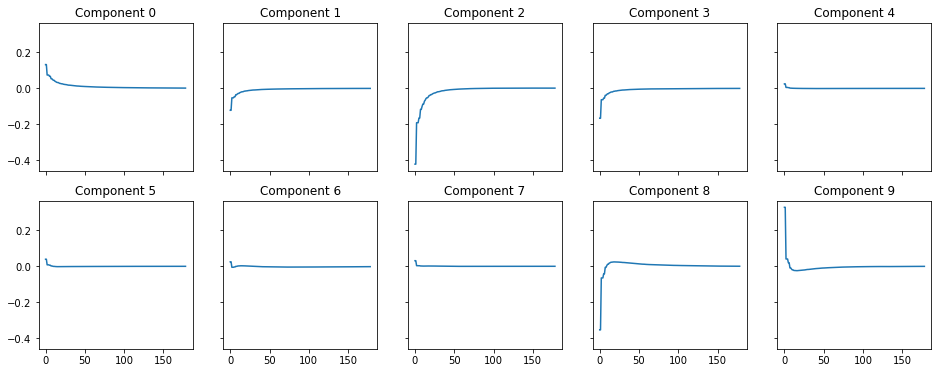

In [28]:
# plot principal axes ARP in feature space (i.e. directions of max variance)
eigenvecs = pca.components_
eigenvecs_tmp = eigenvecs # - eigenvecs.min() # make sure everything is positive
for imgi in range(2):
    print ('Image {}: PCA principal axes ARP (arcsinh'.format(imgi))
    fig,axs=plt.subplots(2,5,figsize=(16,6), sharex=True, sharey=True)
    # for each eigenvector, compute the ARP of each 'image'
    for comp,ax in zip(range(eigenvecs_tmp.shape[0]),axs.ravel()):
        _,arp = np.arcsinh(calculate_arp(reshape_input(eigenvecs_tmp[comp,:],im_no=imgi)))
        im = ax.plot(arp)
        ax.set_title('Component {}'.format(comp))
    plt.show()
    print()

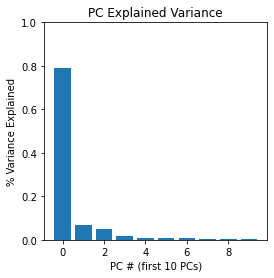

In [29]:
# % explained variance
fig,ax = plt.subplots(figsize=(4,4))
ax.bar(range(len(pca.explained_variance_))[:10],pca.explained_variance_ratio_[:10])
ax.set_xlabel('PC # (first 10 PCs)')
ax.set_ylabel('% Variance Explained')
ax.set_title('PC Explained Variance')
ax.set_ylim((0,1))
plt.show()

Examples of image 0 along as PCs vary independently.


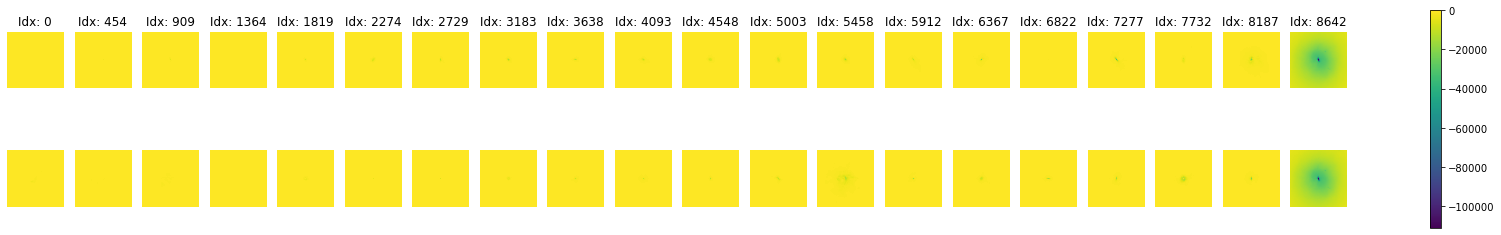

Examples of image 1 along as PCs vary independently.


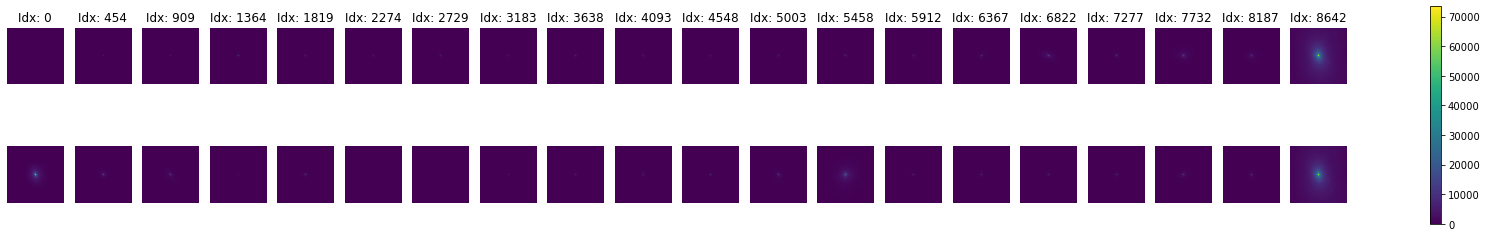

In [30]:
# Plot examples of image 0 and 1 along each PC
npcs = 2
n_samples = 20
sample_idx = np.linspace(0,Xred.shape[0]-1,n_samples).astype(int)

# do everything for image0 and image1
for xri in range(2):
    print('Examples of image {} along as PCs vary independently.'.format(xri))
    fig,ax = plt.subplots(npcs,n_samples,figsize=(30,2*npcs))
    figmin = np.min(Xraw[:,2601*xri:2601*(xri+1)])
    figmax = np.max(Xraw[:,2601*xri:2601*(xri+1)])
    
    # plot a row for each pc
    for pci in range(npcs):
        sorted_idx = np.argsort(Xred[:,pci])
        samples_to_plot = sorted_idx[sample_idx]

        # plot each n_samples samples for this image# and pc#
        for i in range(n_samples):
            im = ax[pci,i].imshow(reshape_input(Xraw[samples_to_plot[i]], im_no=xri), vmin=figmin, vmax=figmax)
            # ax[pci,i].set_yticklabels([])
            # ax[pci,i].set_xticklabels([])
            ax[0,i].set_title('Idx: {}'.format(sample_idx[i]))
            ax[pci,i].axis('off')
            
    ax[0,0].set_ylabel('PC0')
    ax[1,0].set_ylabel('PC1')

    fig.colorbar(im, ax=ax)
    plt.show()

In [31]:
# Plot examples of image 0 and 1 along each PC, as ARP
from matplotlib.pyplot import cm
from galaxy_util import multiline

# constants
npcs = 2
n_samples = 20
cmap = cm.rainbow(np.linspace(0,1,n_samples))
sample_idx = np.linspace(0,Xred.shape[0]-1,n_samples).astype(int)
# do everything for image0 and image1
for xri in range(2):
    print('Examples of image {} ARP as PCs vary independently.'.format(xri))
    fig,ax = plt.subplots(1,npcs,figsize=(16,4))
    figmin = np.min(Xtmp[:,2601*xri:2601*(xri+1)])
    figmax = np.max(Xtmp[:,2601*xri:2601*(xri+1)])
    
    # plot a row for each pc
    for pci in range(npcs):
        sorted_idx = np.argsort(Xred[:,pci])
        samples_to_plot = sorted_idx[sample_idx]

        # plot each n_samples samples for this image# and pc#
        arps = np.zeros((n_samples,200))
        for i in range(n_samples):
            _,arp = calculate_arp(reshape_input(Xtmp[samples_to_plot[i],:], im_no=xri))           
            arps[i,:] = arp
            ax[pci].loglog(arp, c=cmap[i])
        # im = multiline(np.tile(range(arps.shape[1]),(n_samples,1)), arps, sample_idx, ax=ax[pci], cmap='rainbow')
        # axcb = fig.colorbar(im, ax=ax[pci])
        axcb.set_label('PC Index')
        ax[pci].set_xlabel('Radius')
        ax[pci].set_ylabel('Average value')
        ax[pci].set_title('Image {}, PC {}'.format(xri, pci))
        # ax[pci].set_xscale("log")
        # ax[pci].set_yscale("log")
        # ax[pci].set_xlim((0,200))
        # ax[pci].set_ylim((np.nanmin(arps), np.nanmax(arps)))

        # ax[pci].set_xlim((0,200))
    # fig.subplots_adjust(right=0.8)
    # cax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
    # cbar = fig.colorbar(im, ticks=sample_idx)
    # cbar.ax.set_yticklabels(sample_idx)

    # fig.colorbar(im, ax=ax)
    plt.show()

Examples of image 0 ARP as PCs vary independently.


NameError: name 'axcb' is not defined

# Macrovariable Conditional Probability

We now have macrovariables on the X side and 6 microvariable parameters on the Y side. We want to know what the distribution of each Y parameter looks like given each X macrovariable class.

Histograms of each Y parameter given each X macrovariable class. Histograms are normalized so the sum equals to 1. Red = mean of sample.


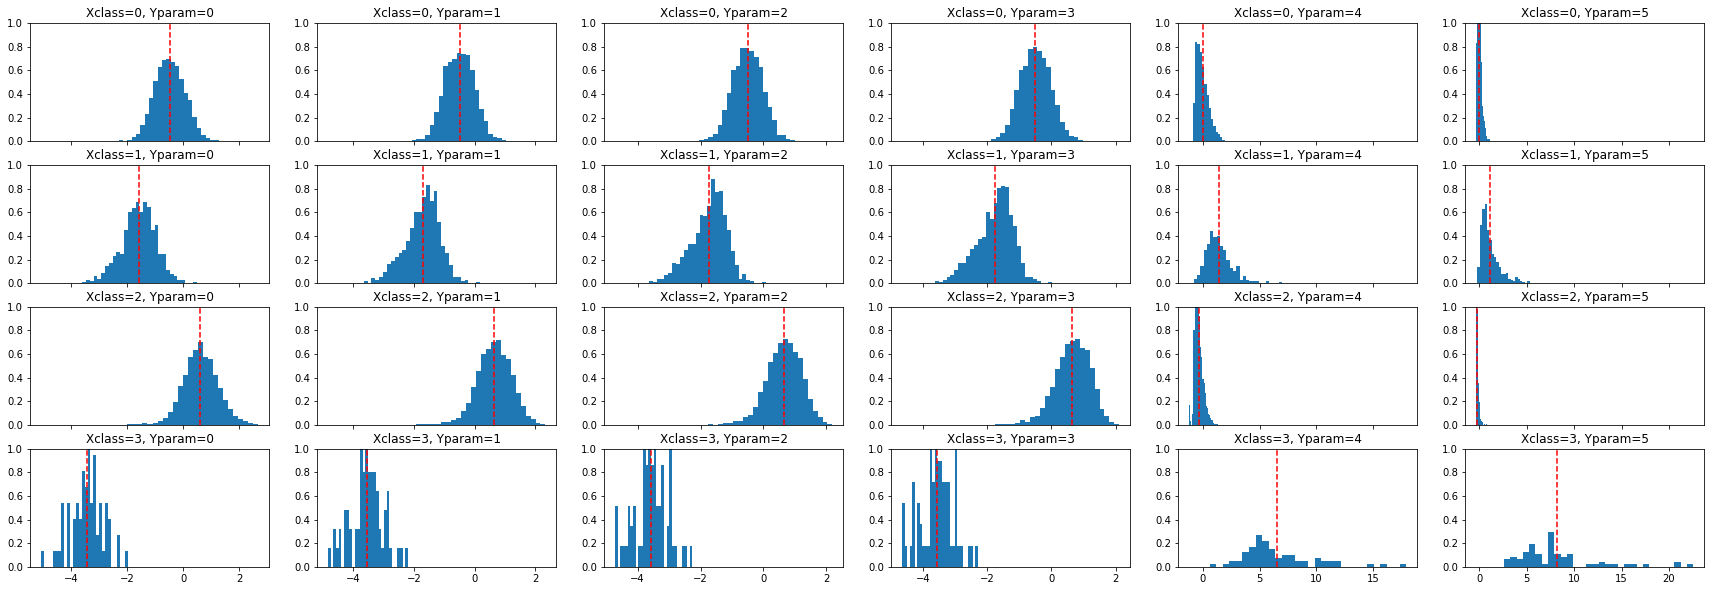

In [125]:
print('Histograms of each Y parameter given each X macrovariable class. Histograms are normalized so the sum equals to 1. Red = mean of sample.')
fig,ax = plt.subplots(cluster_params['n_Xclusters'], dataset1.Y.shape[1], figsize=(30,10),sharex='col')

for xclassidx in range(cluster_params['n_Xclusters']):
    corresponding_yparams = dataset1.Y[xlbls==xclassidx,:]
    for yparamidx in range(dataset1.Y.shape[1]):
        ax[xclassidx,yparamidx].hist(corresponding_yparams[:,yparamidx],density=True, bins=30)
        ax[xclassidx,yparamidx].set_title('Xclass={}, Yparam={}'.format(xclassidx,yparamidx))
        ax[xclassidx,yparamidx].set_ylim((0,1))
        ax[xclassidx,yparamidx].axvline(corresponding_yparams[:,yparamidx].mean(),c='red', linestyle='--')
# resolve original Y distributions before considering these

No handles with labels found to put in legend.
No handles with labels found to put in legend.


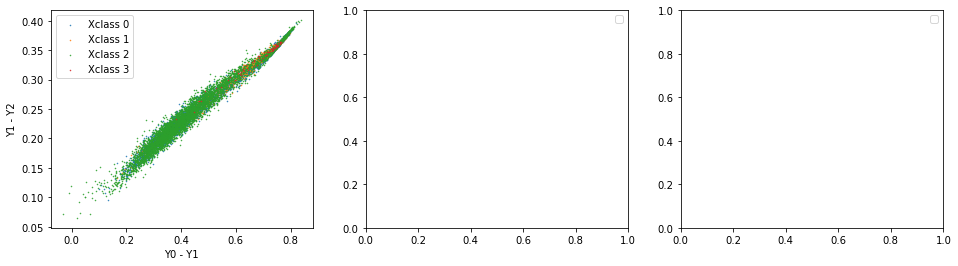

In [69]:
fig,ax = plt.subplots(1,3, figsize=(16,4))
alpha = 0.2
colors = ['red', 'green', 'orange', 'blue']

for xclassidx,col in zip(range(cluster_params['n_Xclusters']), colors):
    class_yparams = Yraw[xlbls==xclassidx,:]
    ax[0].scatter(class_yparams[:,0]-class_yparams[:,1], class_yparams[:,1]-class_yparams[:,2], marker='.', s=1, label='Xclass {}'.format(xclassidx))
    ax[0].set_xlabel('Y0 - Y1')
    ax[0].set_ylabel('Y1 - Y2')
    # ax[1].scatter(class_yparams[:,1]-class_yparams[:,2], class_yparams[:,2]-class_yparams[:,3],facecolors='none', edgecolors=col, s=50, alpha=alpha, label='Xclass {}'.format(xclassidx))
    # ax[1].set_xlabel('Y1 - Y2')
    # ax[1].set_ylabel('Y2 - Y3')
    # ax[2].scatter(class_yparams[:,4], class_yparams[:,5],facecolors='none', edgecolors=col, s=50, alpha=alpha, label='Xclass {}'.format(xclassidx))
    # ax[2].set_xlabel('Y4')
    # ax[2].set_ylabel('Y5')
for i in range(3):
    ax[i].legend()

plt.show()

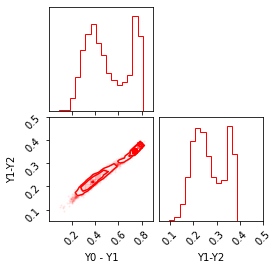

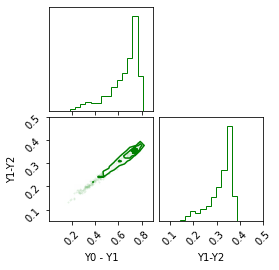

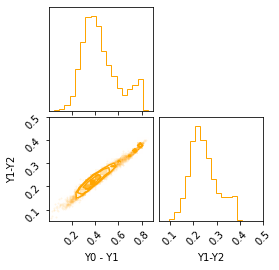

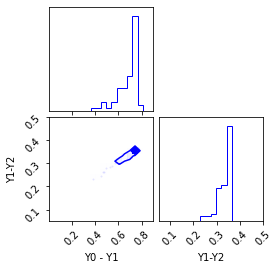

In [118]:
from corner import corner
for xclassidx,col in zip(range(cluster_params['n_Xclusters']), colors):
    fig,ax = plt.subplots(2,2,figsize=(4,4))
    class_yparams = Yraw[xlbls==xclassidx,:]
    corner(np.vstack([class_yparams[:,0]-class_yparams[:,1], class_yparams[:,1]-class_yparams[:,2]]).T,range=[(0,.9),(0.05,.5)], fig=fig, color=col, labels=['Y0 - Y1', 'Y1-Y2'])
    plt.savefig('figures/cond_dist_0m1_1m2_class{}'.format(xclassidx))

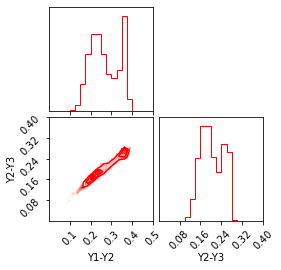

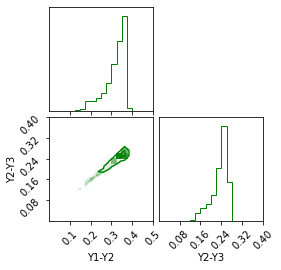

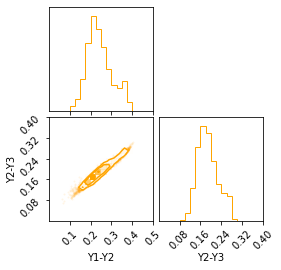

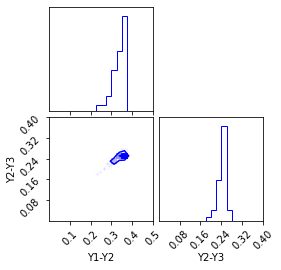

In [124]:
from corner import corner
for xclassidx,col in zip(range(cluster_params['n_Xclusters']), colors):
    fig,ax = plt.subplots(2,2,figsize=(4,4))
    class_yparams = Yraw[xlbls==xclassidx,:]
    corner(np.vstack([class_yparams[:,1]-class_yparams[:,2], class_yparams[:,2]-class_yparams[:,3]]).T,range=[(0,.5),(0,.4)], fig=fig, color=col, labels=['Y1-Y2', 'Y2-Y3'])
    plt.savefig('figures/cond_dist_1m2_2m3_class{}'.format(xclassidx))

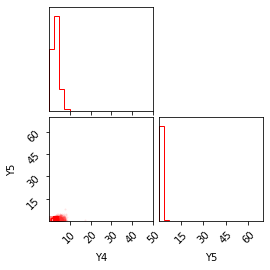

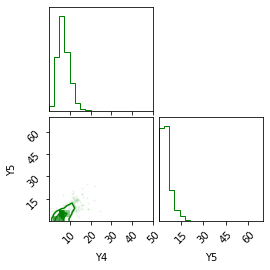

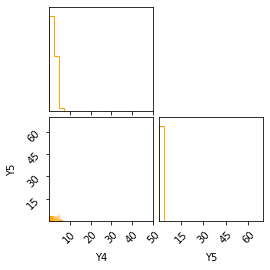

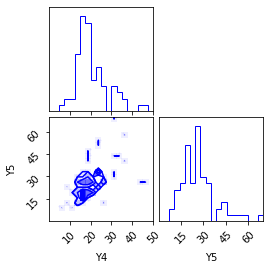

In [120]:
from corner import corner
for xclassidx,col in zip(range(cluster_params['n_Xclusters']), colors):
    fig,ax = plt.subplots(2,2,figsize=(4,4))
    class_yparams = Yraw[xlbls==xclassidx,:]
    corner(np.vstack([class_yparams[:,4], class_yparams[:,5]]).T,range=[(0,50),(0,70)], fig=fig, color=col, labels=['Y4', 'Y5'])
    plt.savefig('figures/cond_dist_4_5_class{}'.format(xclassidx))

# We want to distinguish these distributions in higher dimensions, so we will plot 0-1 vs 1-2 to start

### To Do Summary
- PCA by class, compare eigenvectors, compare examples as PCs vary
- Run all of PCA with untransformed X, image0 and image1 together
- pick something to compare across # clusters
- what is the relationship between image0 and image1, things are so similar?